In [1]:
!pip install pydub

In [2]:
!pip install datasets
!pip install accelerate
!pip install sounddevice

In [3]:
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from datasets import load_dataset


device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "openai/whisper-large-v3"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, use_safetensors=True, #low_cpu_mem_usage=True,
)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)
pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    max_new_tokens=128,
    chunk_length_s=30,
    batch_size=16,
    return_timestamps=True,
    torch_dtype=torch_dtype,
    device=device,
)

#dataset = load_dataset("distil-whisper/librispeech_long", "clean", split="validation")
#sample = dataset[0]["audio"]

#result = pipe(sample)
#print(result["text"])


2024-05-18 15:51:38.066696: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 15:51:38.066844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 15:51:38.197931: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
import pydub
import matplotlib.pyplot as plt
import numpy as np


def read(f, normalized=False):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y

def create_sample(np_audio, sr, path):
    """Create sample from numpy array"""
    d = {"audio":
          {"path": path,
          "array":np_audio,
          "sampling_rate": sr,
          }
         }
    return d

audio_path = "/kaggle/input/hack-db/train_RZHD_AnalizatorPeregovorov/02.05.2024 01_34_17.mp3"
audio = read(audio_path, True)
audio

(8000,
 array([ 0.        ,  0.        ,  0.        , ..., -0.00109863,
        -0.00109863, -0.00143433], dtype=float32))

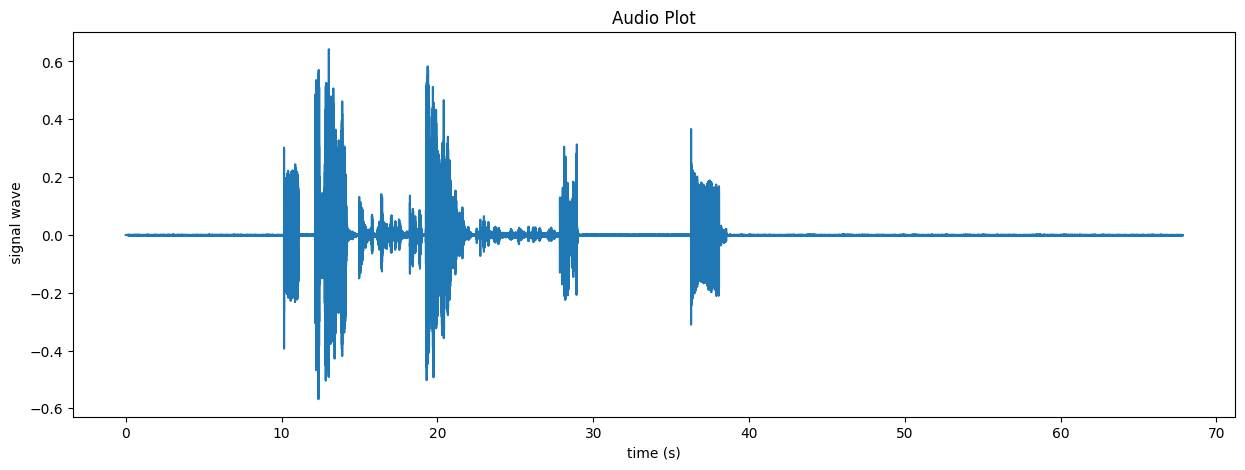

In [7]:
signal_array = audio[1]
sr = audio[0]

n_samples = len(signal_array)

duration = n_samples/sr

time = np.linspace(0, duration, num=n_samples)

plt.figure(figsize=(15, 5))
plt.plot(time, signal_array)
plt.title('Audio Plot')
plt.ylabel(' signal wave')
plt.xlabel('time (s)')
#plt.xlim(0, time) #limiting the x axis to the audio time
plt.show()

In [8]:
from IPython.display import Audio, display

display(Audio(signal_array, autoplay=False, rate=sr))

In [9]:
create_sample(signal_array, sr, audio_path)

{'audio': {'path': '/kaggle/input/hack-db/train_RZHD_AnalizatorPeregovorov/02.05.2024 01_34_17.mp3',
  'array': array([ 0.        ,  0.        ,  0.        , ..., -0.00109863,
         -0.00109863, -0.00143433], dtype=float32),
  'sampling_rate': 8000}}

In [10]:
import re
def speech2voice(path):
    audio = read(path, True)
    signal_array = audio[1]
    sr = audio[0]

    sample = create_sample(signal_array, sr, path)

    result = pipe(sample["audio"], generate_kwargs={"language": "russian"})
    result = re.sub("Продолжение следует...","", result["text"])
    return result

In [11]:
sample = create_sample(signal_array, sr, audio_path)

result = pipe(sample["audio"], generate_kwargs={"language": "russian"})
print(result["text"])

Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


 Продолжение следует... открыто отправлять и дэнс очищен карума Продолжение следует...


In [ ]:
speech2voice("/kaggle/input/hack-db/train_RZHD_AnalizatorPeregovorov/ElevenLabs 29�_874 �� - 02.05.2024 01_08_44.mp3")

In [12]:
sent1 =  """3576 у входного станции Есаульская, ответьте поездному
3576 на перегоне Ишалино Есаульская, у входного станции Есаульская, машинист Васильев, слушаю вас
Машинист до Шагла разгоняемся, проходы оперативнее делаем, на скрещение с Орланом будем по станции Шагол
Понятно, скрещение с Орланом по станции Шагол 3576 машинист Васильев
"""
sent2 =  """Машинист поезда 3576 у входного станции Есаульская
Слушая вас, машинист 3576 Васильев
Машинист 3576 по станции Шагол  проследовать на 10:20, скрещение с Орланом. ДНЦ ФИО
Понятно, по станции Шагол проследовать на 10:20 , скрещение с Орланом машинист Васильев
«Верно».
"""

template = """Машинист поезда №2120  на 5-м пути станции К». 
Слушаю Вас, машинист поезда №2120 Иванов.
Приказ №1 время 1:30 (один час, тридцать минут). Разрешаю поезду №2120 отправиться
с 5-го пути по четному главному пути при запрещающем показании выходного светофора Ч5 и следовать до выхода на перегон со скоростью 20 км/час, а далее руководствоваться сигналами локомотивного светофора. 
ДСП Петрова.
Понятно.
Приказ №1 :30 (один час, тридцать минут). Разрешаете поезду №2120 отправиться с 5-го пути по четному главному пути при запрещающем показании выходного светофораЧ5 и следовать до выхода на перегон со скоростью 20 км/час, а далее руководствоваться сигналами локомотивного светофора. 
Машинист поезда №2120 Иванов.
 Верно, выполняйте 
"""

template2 = """Машинист поезда №2120на приближении к станции К.
Слушаю Вас, машинист поезда №2120 Иванов.
Машинист поезда 2120, следующего к станции К
По входной стрелке №2, скорость не более 40 км/час. Приказ №5 от 23.04.2024 г. (допускается сказать цифрами и словами) подписывает ПЧ Федоров.
ДСП Петрова.
Понятно.
По входной стрелке №2 скорость не более 40 км/час. Приказ № 5 от 23.04.2024 г. подписывает подписывает ПЧ Федоров.
Машинист поезда №2120 Иванов.
Верно. 
"""

template3 = """Машинист поезда №2120 на приближении к станции К». 
Слушаю Вас, машинист поезда №2120 Иванов.
Указание № 2 время  1 час 40мин. Машинисту поезда № 2120 
Я, дежурный по станции К, разрешаю Вам следовать на свободный участок занятого 6 пути при запрещающем показании входного  светофора Ч.  Маршрут приема готов. Участок приема от выходного светофора  Н6 свободен на 20 вагонов. 
ДСП Петрова
Понятно.
Указание № 2время 1 час 40минут. Разрешаете следовать на свободный участок занятого 6 пути при запрещающем показании входного  светофора Ч.  Маршрут приема готов. Участок приема от выходного светофора  Н6 свободен на 20 вагонов. 
Машинист поезда № 2120 Иванов.
 Верно выполняйте. 

"""

template4 = """«Составитель Иванов, машинист 34.
Довожу план маневровой работы. С 1 пути 10 вагонов переставьте со стороны нечетной горловины на 2 путь и объедините с 15 вагонами. Вытягиваться будем по направлению четного пути с выездом за светофор М5
ДСП  Петрова
«Понятно. По плану маневровой работы будем с 1 пути 10 вагонов переставлять со стороны нечетной горловины на 2 путь и объединять с 15 вагонами. Вытягиваться будем по направлению четного пути с выездом за светофор М5
Составитель  Сидоров.
«Понятно. По плану маневровой работы будем с 1 пути 10 вагонов переставлять со стороны нечетной горловины на 2 путь и объединять с 15 вагонами. Вытягиваться будем по направлению четного пути  с выездом за светофор М5
Машинист 34».
«Верно».
"""


template5 = """«Машинист 34, составитель Сидоров.
Открываю Вам светофор М1 до М9 запрещающего.  
ДСП Петрова».
«Понятно, светофор М1 открываете до М9 запрещающего.  
Составитель Сидоров».
«Верно. ДСП Петрова».
Открывает светофор М1 до М9.
«Машинист 34, поехали вперед до М9 запрещающего. М1 белый, я на подножке справа (слева, на площадке, в тамбуре, иду пешком справа по ходу и т.д.)».
«Понятно, еду вперед до М9 запрещающего. М1 белый».
«Машинист 34, остановка».
"""


template6 = """«Составитель Сидоров. Машинист 34.
На 5 пути прекратите маневры, на 6 путь принимаю поезд. ДСП Петрова».
«Машинист 34, остановка».
«Дежурный, на 5 пути маневры прекращены, стоим. Составитель Сидоров».
«Дежурный, на 5 пути маневры прекращены, стоим. Машинист 34».
"""

template7 = """«Машинист 34.
Довожу план маневровой работы. С 1 пути  будем переезжать через нечетную горловину на 4 свободный (занятый) путь. Вытягиваться будем по направлению нечетного пути с выездом за светофор М1.
ДСП Сидорова.»
«Понятно. По плану маневровой работы. С 1 пути  будем переезжать через нечетную горловину на 4 свободный (занятый) путь. Вытягиваться будем по направлению нечетного пути  с выездом за светофор М1.
Машинист 34 ».
«Верно.»
"""

In [13]:
sent3 =  """Машинист поезда 2675 на перегоне Лебяжья-Сибирская Кравцево
машинист 2675  Гибриткин, слушаю 
Машинист 2675 следуем максимально по станции Кравцево проследовать 13:20, за вами пакет нечетных поездов, ДНЦ Фамилия
Понятно. Следую максимально допустимо по станции Крацево проследовать в 13:20, за нами пакет нечетных. машинист 2675 Гибриткин
«Верно».
"""

sent4 =  """____Мая 2024 время на часах 5 часов 2 минуты, перегон Тамерлан-Тумак, нечетный путь 107ой км, пикет 6-ой, скорость всем поездам 60, перекос пути. 22 на 15, передал ПС Синьков
Понятно, телефонограмма номер 9, время  5 часов 02 минуты, перегон Тамерлан-Тумак, нечетный путь, 107 км, пикет 6ой, всем поездам скорость 60 км в час, перекос пути, передал ПС Синьков, приняла ДНЦ Бочкарева
Все верно, спасибо
"""

In [14]:
!pip3 install -U spacy
!python3 -m spacy download ru_core_news_sm
!pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 41.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: spacy
    Found existing installation: spacy 3.7.3
    Uninstalling spacy-3.7.3:
      Successfully uninstalled spacy-3.7.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 57.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 59.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 3.8 MB/s eta 0:00:00a 0:00:01


In [16]:
from gensim.parsing.preprocessing import stem_text
import re
import numpy as np
import spacy
from nltk.corpus import stopwords

nlp = spacy.load("ru_core_news_sm")
stoplist = set(stopwords.words('russian'))


def proccess_text(sent, 
                  remove_ners=True, 
                  remove_stop_words=True,
                  remove_nums=True):
    doc = nlp(sent)
    new_text = doc.text
    if remove_ners:
        for word in list(doc.ents) :
            #print(word.text, word.label_)
            #print(word)
            new_text = re.sub(word.text, "", new_text)
    
    if remove_stop_words:
        prep_text = ""
        for word in new_text.split(" "):
            if word not in stoplist:
                prep_text += word + " " 
        new_text = prep_text
    
    new_text = re.sub("\n", "", new_text)
    stem_sent = stem_text(new_text)
    
    if remove_nums:
        stem_sent = re.sub('[0-9]+', 'число', stem_sent)

    return stem_sent

proccess_text(sent4)

'____мая число время часах число часов число минуты, перегон , нечетный путь числоой км, пикет число-ой, скорость всем поездам число, перекос пути. число число, передал , телефонограмма номер число, время число часов число минуты, перегон , нечетный путь, число км, пикет числоой, всем поездам скорость число км час, перекос пути, передал , приняла все верно, спасибо'

In [17]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("all-MiniLM-L6-v2")

def get_cosine_scores(list1, 
                     list2, 
                     remove_ners=True, 
                     remove_stop_words=True,
                     remove_nums=True):
    templates = list1
    for i in range(len(templates)):
        templates[i] = proccess_text(templates[i], remove_ners, remove_stop_words, remove_nums)
    
    sentences = list2
    for i in range(len(sentences)):
        sentences[i] = proccess_text(sentences[i], remove_ners, remove_stop_words, remove_nums)
    
    embeddings1 = model.encode(sentences, convert_to_tensor=True)
    embeddings2 = model.encode(templates, convert_to_tensor=True)
    cosine_scores = util.cos_sim(embeddings1, embeddings2)

    return cosine_scores

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [18]:

templates = [template, template2,template3, template4, template5, template6, template7]

sentences = [sent1, sent2] # , sent3, sent4


get_cosine_scores(templates, sentences)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

tensor([[0.7899, 0.7326, 0.7782, 0.6908, 0.6612, 0.7550, 0.6729],
        [0.6657, 0.6539, 0.6139, 0.5786, 0.5831, 0.7514, 0.5772]],
       device='cuda:0')

In [19]:
import pandas as pd

df = pd.read_csv("/kaggle/input/hack-db/train_RZHD_AnalizatorPeregovorov/data.csv", delimiter=";").sample(frac = 1)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, 38 to 0
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    44 non-null     object
 1   text    44 non-null     object
 2   target  44 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.4+ KB


In [21]:
decoded_texts = []
root_path = "/kaggle/input/hack-db/train_RZHD_AnalizatorPeregovorov/"
for i in range(len(df.path)):
    if df.iloc[i].path == "generated":
        decoded_texts.append(df.iloc[i].text)
    else:
        decoded = speech2voice(root_path + df.iloc[i].path)
        decoded_texts.append(decoded)


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.
--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 1100, in emit
    msg = self.format(record)
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 943, in format
    return fmt.format(record)
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 678, in format
    record.message = record.getMessage()
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 368, in 

In [22]:
#texts = list(df.text)

# Compute cosine-similarities
cosine_scores = get_cosine_scores(templates, decoded_texts, 
                     remove_ners=True, 
                     remove_stop_words=True,
                     remove_nums=True)

X = cosine_scores[6:].cpu().numpy()
y = df[6:].target
X_test = cosine_scores[:6].cpu().numpy()
y_test = df[:6].target

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
df.iloc[4].text

'Машинист поезда 4392 Трифонов, диспетчеру ответьте. 4392 машинист Трифонов проследую 2276 пост, слушаю вас. У нас на входной Ч открыт на второй путь, на выход сигнал Ч-2 закрыт, на стоянку пропускаем нечетное ДНЦ.  4392 машинист Трифонов следует на станцию Лабазу по 277 км, я вас понял. Лабазу сигнал Ч открыт, на второй главный свободный, Ч-2 сигнал закрыт. Скрещение с нечетным. Машинист Трифонов принял. Верно, выполняйте. Выполняем'

In [24]:
df.iloc[4].target

1

In [25]:
df.iloc[4].path

'02.05.2024 07_07_13.mp3'

In [26]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression


clf = LogisticRegression().fit(X, y)
print(clf.predict(X_test), y_test)
print(clf.predict_proba(X_test))
print(clf.score(X, y))
print(clf.score(X_test, y_test))

#save
#with open('model.pkl','wb') as f:
#    pickle.dump(clf,f)

# load
#with open('model.pkl', 'rb') as f:
#    clf2 = pickle.load(f)

[1 0 1 0 0 0] 38    1
43    0
26    1
16    0
2     1
33    0
Name: target, dtype: int64
[[0.3201655  0.6798345 ]
 [0.64827022 0.35172978]
 [0.28977631 0.71022369]
 [0.71121631 0.28878369]
 [0.65285913 0.34714087]
 [0.6660928  0.3339072 ]]
0.8421052631578947
0.8333333333333334


In [27]:
!pip install pickle4

  Preparing metadata (setup.py) ... done
  Created wheel for pickle4: filename=pickle4-0.0.1-py2.py3-none-any.whl size=19698 sha256=90b3d0f6e32b988df44971b82fc825b47110c33027813c98746c2eb31aa2ca48
  Stored in directory: /root/.cache/pip/wheels/fa/2c/86/ea9f8f047af128230580d01abee9d5635e287478f9d6c7bd0f
Successfully built pickle4


In [28]:
import pickle

with open('model.pkl','wb') as f:
    pickle.dump(clf,f)

In [ ]:
def get_pred(texts):
    cosine_scores = get_cosine_scores(templates, texts).cpu().numpy()

    return clf.predict(cosine_scores)

In [ ]:
text_test = 'Диспетчер Слушаю, диспетчер. Бочкарева Телефонограмма номер 9 от 02.05.2024 г, время  5 часов 02 минуты, перегон Тамерлан-Тумак, нечетный путь, 107 км, пикет 6-ой, всем поездам скорость 60 км в час, перекос пути, передал ПС Синьков Понятно, телефонограмма номер 9 от 02.05.2024 г. , время  5 часов 02 минуты, перегон Тамерлан-Тумак, нечетный путь, 107 км, пикет 6-ой, всем поездам скорость 60 км в час, перекос пути, передал ПС Синьков, приняла ДНЦ Бочкарева Верно'

get_pred([text_test])